In [5]:
import sys
import os

library_path = '../../SeisRoutine'
sys.path.append(os.path.abspath(library_path))
from SeisRoutine.config import load_config

In [6]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

In [7]:
cfg = load_config('Kaki-cfg.yml')
cfg.training.learning_rate = eval(cfg.training.learning_rate)
# print(cfg)

In [8]:
data = sbd.WaveformDataset(cfg.path.dataset, sampling_rate=100)
train, dev, test = data.train_dev_test()
print(train, dev, test, sep='\n')

2024-10-26 11:33:28,205 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


Unnamed dataset - 25158 traces
Unnamed dataset - 2796 traces
Unnamed dataset - 3107 traces


In [9]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [10]:
train_generator = sbg.GenericGenerator(train)
augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=1000, windowlen=4000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)

In [11]:
indx = 8181#np.random.randint(len(train_generator))
sample = train_generator[indx]

# fig = plt.figure(figsize=(10, 5))
# axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
# axs[0].plot(sample["X"].T)
# axs[1].plot(sample["y"].T);
# print(indx)

x = sample["X"]
y = sample["y"]
x.shape, y.shape

((3, 3001), (3, 3001))

In [12]:
batch_size = 256
num_workers = 4  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=False, num_workers=1, worker_init_fn=worker_seeding)

In [13]:
it = iter(train_loader)

In [14]:
sample = next(it)

8181


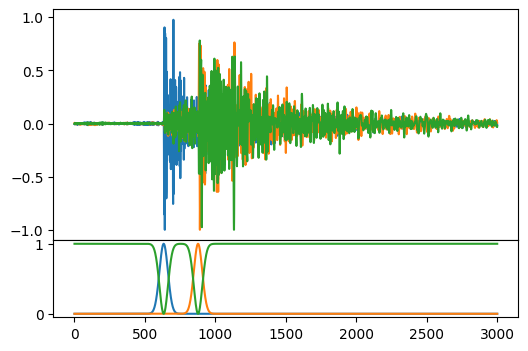

In [15]:
ii = 9
x = sample["X"][ii].unsqueeze(0)
y = sample["y"][ii].unsqueeze(0)
one_sample_data = {'X': sample["X"][ii].unsqueeze(0),
                   'y': sample["y"][ii].unsqueeze(0)}
x.shape, y.shape
fig = plt.figure(figsize=(6, 4))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(x[0].T)
axs[1].plot(y[0].T);
print(indx)

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [110]:
# x = torch.randn(1, 3, 3001)
# y = torch.zeros(1, 3, 3001)
# y[:, 0, 600]  = 1

# y[:, 1, 700]  = 1

# y[:, 2, :] = 1
# y[:, 2, 600]  = 0
# y[:, 2, 700]  = 0
# x.shape, y.shape

In [405]:
torch.manual_seed(42)

class ikpicker(nn.Module):
    def __init__(self):
        super().__init__()
        ###
        self.arch1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3, out_channels=12, kernel_size=15, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3),
        )
        ###
        self.arch2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=12, out_channels=3, kernel_size=7, stride=1,
                padding=2, output_padding=0, bias=True),
            nn.ReLU(),
            nn.Upsample(scale_factor=3),
        )
        self.activ = nn.Softmax(dim=1)
    def forward(self, x, logit=True):
        x = self.arch1(x)
        x = self.arch2(x)
        x = x[:, :, :3001]
        if logit:
            return x
        else:
            return self.activ(x)
        

model = ikpicker()

In [375]:
torch.manual_seed(42)

class ikpicker(nn.Module):
    def __init__(self):
        super().__init__()
        ###
        self.arch1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3, out_channels=12, kernel_size=15, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3),
        )
        ###
        self.arch2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=12, out_channels=3, kernel_size=9, stride=1,
                padding=2, output_padding=0, bias=True),
            nn.Upsample(scale_factor=3),
        )
        self.activ = nn.Softmax(dim=1)
    def forward(self, x, logit=True):
        x = self.arch1(x)
        x = self.arch2(x)
        x = x[:, :, :3001]
        if logit:
            return x
        else:
            return self.activ(x)
        

model = ikpicker()

In [365]:
torch.manual_seed(42)

class ikpicker(nn.Module):
    def __init__(self):
        super().__init__()
        ###
        self.arch1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3, out_channels=12, kernel_size=15, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3),
        )
        ###
        self.arch2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=12, out_channels=3, kernel_size=15, stride=1,
                padding=2, output_padding=0, bias=True),
            nn.Upsample(scale_factor=3),
        )
        self.activ = nn.Softmax(dim=1)
    def forward(self, x, logit=True):
        x = self.arch1(x)
        x = self.arch2(x)
        x = x[:, :, :3001]
        if logit:
            return x
        else:
            return self.activ(x)
        

model = ikpicker()

In [346]:
torch.manual_seed(42)

class ikpicker(nn.Module):
    def __init__(self):
        super().__init__()
        ###
        self.arch1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3, out_channels=12, kernel_size=7, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3),
        )
        ###
        self.arch2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=12, out_channels=3, kernel_size=7, stride=1,
                padding=2, output_padding=0, bias=True),
            nn.Upsample(scale_factor=3),
        )
        self.activ = nn.Softmax(dim=1)
    def forward(self, x, logit=True):
        x = self.arch1(x)
        x = self.arch2(x)
        x = x[:, :, :3001]
        if logit:
            return x
        else:
            return self.activ(x)
        

model = ikpicker()

In [354]:
torch.manual_seed(42)

class ikpicker(nn.Module):
    def __init__(self):
        super().__init__()
        ###
        self.arch1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3, out_channels=12, kernel_size=7, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Conv1d(
                in_channels=12, out_channels=24, kernel_size=7, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3)
        )
        ###
        self.arch2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=24, out_channels=3, kernel_size=7, stride=1,
                padding=0, output_padding=0, bias=True),
            nn.Upsample(scale_factor=9),
        )
        self.activ = nn.Softmax(dim=1)
    def forward(self, x, logit=True):
        x = self.arch1(x)
        x = self.arch2(x)
        x = x[:, :, :3001]
        if logit:
            return x
        else:
            return self.activ(x)
        

model = ikpicker()

In [317]:
torch.manual_seed(42)

class ikpicker(nn.Module):
    def __init__(self):
        super().__init__()
        ###
        self.arch1 = nn.Sequential(
            nn.Conv1d(
                in_channels=3, out_channels=12, kernel_size=7, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3),
            nn.Conv1d(
                in_channels=12, out_channels=24, kernel_size=7, stride=1,
                padding='same', bias=False, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool1d(3)
        )
        ###
        # self.arch1 = nn.Sequential(
        #     nn.Conv1d(
        #         in_channels=12, out_channels=12, kernel_size=9, stride=4,
        #         padding=0, bias=True, padding_mode='zeros'),
        #     nn.ReLU(),
        # )
        ###
        self.arch2 = nn.Sequential(
            nn.ConvTranspose1d(
                in_channels=24, out_channels=3, kernel_size=7, stride=1,
                padding=2, output_padding=0, bias=True),
            nn.Upsample(scale_factor=9),
            # nn.ReLU(),
            # nn.ConvTranspose1d(
            #     in_channels=12, out_channels=3, kernel_size=7, stride=1,
            #     padding=3, output_padding=0, bias=True),
            # nn.Upsample(scale_factor=3),
            # nn.ReLU(),
        )
        self.activ = nn.Softmax(dim=1)
    def forward(self, x, logit=True):
        # print('X-shap input:', x.shape)
        # x = self.preproc(x)
        # print('X-shap After preproc:', x.shape)
        # x = F.pad(x, (1, 3), "constant", 0)
        x = self.arch1(x)
        # x = F.pad(x, (1,0), 'constant', 0)
        # print('X-shap After arch1:', x.shape)
        x = self.arch2(x)
        # print('X-shap After arch2:', x.shape)
        # x = self.activ(x)
        x = x[:, :, :3001]
        if logit:
            return x
        else:
            return self.activ(x)
        

model = ikpicker()

torch.Size([1, 3, 3001]) torch.Size([1, 3, 3001]) torch.Size([1, 3, 3001])


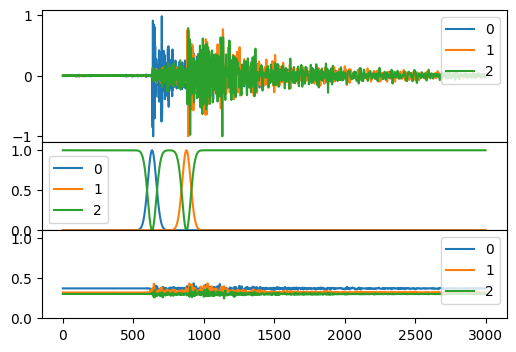

In [406]:
model.eval()
with torch.no_grad():
    y_hat = model(x, logit=False)
    print(x.shape, y.shape, y_hat.shape)

fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 2, 2]})
for ii, _X in enumerate([x, y, y_hat]):
    for i in range(3):
        axs[ii].plot(_X[0, i, :], label=i)
    axs[ii].legend()
axs[1].set_ylim([0, 1.1])
axs[2].set_ylim([0, 1.1]);

In [355]:
def custom_loss(output, target, margin=0.001):
    # محاسبه Cross Entropy Loss
    ce_loss = loss_fn(y_pred=output, y_true=target, eps=1e-5)

    # محاسبه Margin Loss برای اطمینان از فاصله بین احتمالات
    margin_loss = 0
    for t in range(output.size(1)):  # هر لحظه از زمان
        sorted_probs, _ = output[:, t, :].sort(dim=1, descending=True)
        margin_loss += torch.mean((sorted_probs[:, 0] - sorted_probs[:, 1]) ** 2)

    margin_loss /= output.size(1)  # نرمال کردن Margin Loss
    total_loss = ce_loss + margin_loss * margin
    print(f'{ce_loss=:.3f} {margin_loss=:.3f} {total_loss=:.3f}')
    return total_loss

In [366]:
def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h

In [411]:
# model.train()
# loss_fn = nn.CrossEntropyLoss()

epoc_itr = 10
for epochs, lr in [(epoc_itr, 0.1), (epoc_itr, 0.01), (epoc_itr, 0.001), (epoc_itr, 0.0001)]:#((10, 1), (100, 0.1), (1000, 0.01)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=0.5)
    for epoch in range(epochs):
        for batch_id, batch in enumerate([one_sample_data]):
        # for batch_id, batch in enumerate(train_loader):
            x = batch['X']
            y = batch['y']
            y_hat = model(x, logit=False)
            loss = loss_fn(y_hat, y)
            loss = loss.mean()
            # loss = custom_loss(y_hat, y)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # if epoch % epochs//10 == 0:
    loss = loss.mean()
    print(f"Epoch {epoch+1}   {lr=}\n-------------------------------")
    print(f'Loss: {loss}')

Epoch 10   lr=0.1
-------------------------------
Loss: 0.19844471630687333
Epoch 10   lr=0.01
-------------------------------
Loss: 0.19101918984264582
Epoch 10   lr=0.001
-------------------------------
Loss: 0.18972425181633573
Epoch 10   lr=0.0001
-------------------------------
Loss: 0.18955481779383995


torch.Size([1, 3, 3001]) torch.Size([1, 3, 3001]) torch.Size([1, 3, 3001])


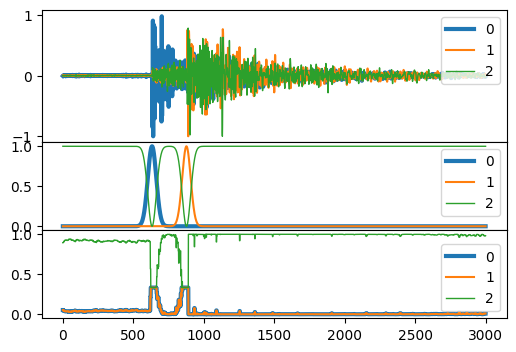

In [412]:
# model.eval()
with torch.no_grad():
    y_hat = model(x, logit=False)
    print(x.shape, y.shape, y_hat.shape)

fig, axs = plt.subplots(3, 1, figsize=(6, 4), sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 2, 2]})
for ii, _X in enumerate([x, y, y_hat]):
    for i in range(3):
        axs[ii].plot(_X[0, i, :], label=i, lw=3/(i+1))
    axs[ii].legend()
# axs[1].set_ylim([-0.1, 1.1])
# axs[2].set_ylim([-0.1, 1.1]);